In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
%%capture
np.random.seed(0)
torch.manual_seed(0)

In this demo, we will show how vanilla Recurrent Neural Networks (RNNs) can be used to solve time-series extrapolation problems -- That is, problems that require you to predict the "next value" given a series of values.

# Generate Data

Here, we will try to use a RNN to predict a sine wave. We create a dataset consisting of a random length of a sine wave with Gaussian noise.

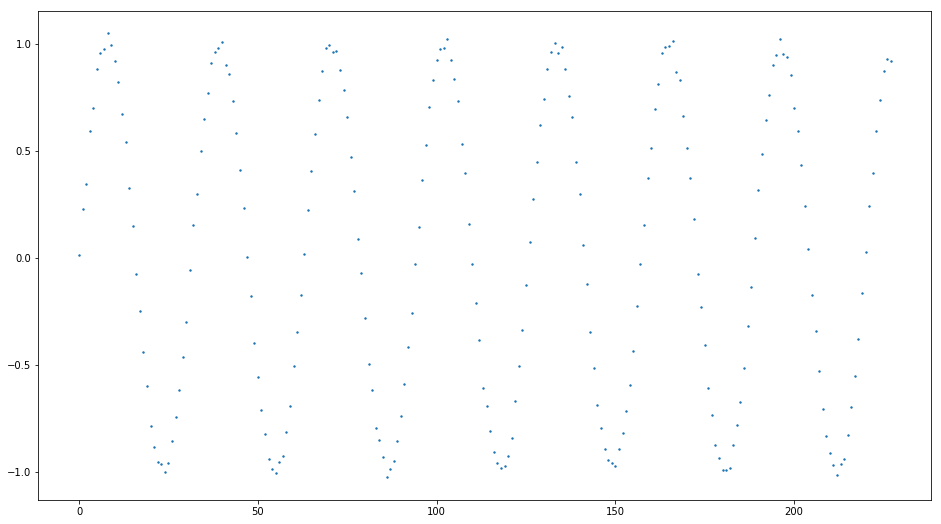

In [3]:
SIGMA = 0.02
N = 20

dataset = []

for _ in range(N):
    end = np.random.uniform(40, 50)
    t = np.arange(0, end, 0.2)
    x = np.sin(t) + np.random.normal(loc=0.0, scale=SIGMA, size=t.shape)
    dataset.append(x)

plt.figure(figsize=(16, 9))
plt.scatter(np.arange(dataset[0].shape[0]), dataset[0], s=2)
plt.show()

In [4]:
dataset = [
    (torch.from_numpy(input_seq[:-1]).double(), torch.from_numpy(input_seq[1:]).double()) \
        for input_seq in dataset
]

In [5]:
class RNN(nn.Module):
    
    def __init__(self, hidden_size):
        
        super().__init__()
        
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size=1, hidden_size=self.hidden_size)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)
        
        
    def forward(self, inputs, teacher_force_prob=0.5):
        
        initial_h = self.get_initial_h()
        seq_len = inputs.shape[0]
        
        outputs = []
        h = initial_h
        for i, inp in enumerate(inputs):
            if i == 0 or np.random.uniform() < teacher_force_prob:
                inp_to_rnn = inp
            else:
                inp_to_rnn = output
            output, h = self.rnn(inp_to_rnn.reshape(1, 1, 1), h)
            output = self.linear(torch.squeeze(output))
            outputs.append(output)
        final_h = h
        
        outputs = torch.squeeze(torch.cat(outputs))
        
        return outputs, final_h
    
    
    def get_initial_h(self):
        
        return torch.zeros(1, 1, self.hidden_size).double()
    
    
    def extrapolate(self, inputs, num_futures):
        
        with torch.no_grad():
            
            outputs, final_h = self.forward(inputs)
            
            future_points = []
            h = final_h
            pred_pt = outputs[-1]
            
            for _ in range(num_futures):
                pred, h = self.rnn(pred_pt.reshape(1, 1, 1), h)
                pred_pt = self.linear(pred)
                future_points.append(pred_pt.item())
                
            future_points = np.array(future_points)
            return np.concatenate((outputs.numpy().reshape(-1), future_points))
                


In [6]:
EPOCHS = 35
LR = 0.05
BETA = 0.2
HIDDEN_SIZE = 64

net = RNN(HIDDEN_SIZE).double()

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=BETA)

for _ in range(EPOCHS):
    
    total_loss = 0
    
    for inputs, target in dataset:
        
        output, _ = net(inputs)
        output = output.reshape(-1)
        loss = criterion(output, target)
        
        total_loss += loss
        
    total_loss /= len(dataset)
    
    print(total_loss.item())
    net.zero_grad()
    total_loss.backward()
    optimizer.step()
    

0.48566103019178974
0.4647559270155062
0.4444063661449832
0.43230205037926855
0.41534796511189054
0.4008884137693096
0.38482225136970605
0.3697960264749077
0.34997113765393056
0.3239724257331065
0.3126405184586418
0.27457179470255244
0.24917313907723856
0.2287570929077405
0.19688447963695171
0.1735985909482733
0.15376114830145834
0.15268295685069838
0.13712003810005707
0.11950104799922032
0.11282153274925674
0.09606469198828863
0.07439901780530087
0.0619022577143745
0.041953968941428624
0.029250253826791132
0.02759950948380267
0.051585699401869876
0.11112835749154555
0.3361293153201116
0.07016812467629702
0.034137434487751146
0.031239621254512295
0.020939420228636457
0.01690055007913557


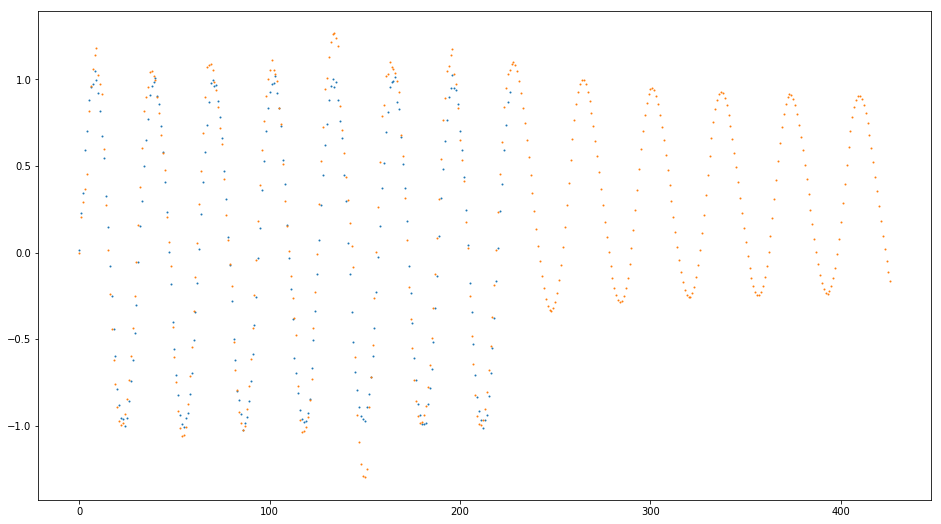

In [7]:
num_future = 200

ground = dataset[0][0]
num_ground = ground.shape[0]
prediction = net.extrapolate(ground, num_future)

plt.figure(figsize=(16, 9))
plt.scatter(np.arange(0, num_ground), ground, s=1)
plt.scatter(np.arange(num_ground + num_future), prediction, s=1)
plt.show()